In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters of  problem
# Number of PEVGs

In [2]:

N = 5  

# Grid capacity (MWh)
C = 99  

# Battery capacities
# b_n = np.array([50, 60, 40, 55, 45])  
b_n = []
for i in range(N):
    b_n.append( random.randint(45,65) )

# Satisfaction parameters
# s_n = np.array([1, 1.2, 1.5, 1.1, 1.3])  
s_n = []
for i in range(N):
    s_n.append( random.uniform(1,2) )

b_n = np.array(b_n)
s_n = np.array(s_n)

In [3]:
# Swarm size
n_particles = 100  

# Number of iterations
n_iterations = 150
w = 0.7  
c1 = 2.0  
c2 = 2.0  

# Archive size for non-dominated solutions
max_archive_size = 100  

# Bounds
lb = np.array([20] + [0] * N)  # Lower bounds: p >= 0, x_n >= 0
ub = np.array([50] + [min(b_n[i], C) for i in range(N)])  # Upper bounds: p <= 65, x_n <= b_n

In [4]:
obj1 = []
obj2 = []

In [5]:
def findbest_1():
    p = -1

    # if( len(obj1) != 0):
    #     p = obj1[-1]

    # if( len(archive) != 0 and p<archive[-1][1][1]):
    #     p = archive[-1][1][0]

    # if(len(archive) != 0):
    #     p = archive[-1][1][0]
    
    for obj in archive:
        if p < obj[1][0]:
            p  = obj[1][0]
            # print(p)
    obj1.append(p)

In [6]:
def findbest_2():
    p = -1

    if( len(obj2) != 0):
        p = obj2[-1]

    # if( len(archive) != 0 and p<archive[-1][1][1]):
    #     p = archive[-1][1][1]
    
    for obj in archive:
        if p < obj[1][1]:
            p  = obj[1][1]
            # print(p)
    obj2.append(p)

# Objective functions

In [7]:

def evaluate_objectives(X):
    p = X[0]
    x_n = X[1:]
    revenue = p * np.sum(x_n)
    utility = np.sum(b_n * x_n - 0.5 * s_n * x_n**2 - p * x_n)
    
    # constrains
    wastage = np.sum(x_n) - C
    return np.array([revenue, utility])  # Maximize revenue, utility, minimize wastage (negated)

In [8]:
# Check dominance
def dominates(obj1, obj2):
    return (obj1[0] >= obj2[0] and obj1[1] >= obj2[1] ) and \
           (obj1[0] > obj2[0] or obj1[1] > obj2[1] )

In [9]:
# Initialize particles
np.random.seed(42)
positions = np.random.uniform(lb, ub, (n_particles, N + 1))
velocities = np.random.uniform(-1, 1, (n_particles, N + 1)) * (ub - lb) * 0.1
pbest_positions = positions.copy()
pbest_objectives = np.array([evaluate_objectives(pos) for pos in positions])
archive = []  # Non-dominated solutions

In [10]:
# Initialize archive with initial non-dominated solutions
for i in range(n_particles):
    dominated = False
    for j in range(len(archive)):
        if dominates(archive[j][1], pbest_objectives[i]):
            dominated = True
            break
    if not dominated:
        archive.append((positions[i].copy(), pbest_objectives[i].copy()))
        # Remove dominated solutions from archive
        archive = [sol for sol in archive if not dominates(pbest_objectives[i], sol[1])]
        if len(archive) > max_archive_size:
            archive.pop(np.random.randint(len(archive)))

# Particle Swarm Optimization

In [11]:
for iteration in range(n_iterations):
    for i in range(n_particles):
        # Enforce constraint: sum(x_n) <= C
        x_n = positions[i, 1:]
        if np.sum(x_n) > C:
            x_n = x_n * C / np.sum(x_n)
            positions[i, 1:] = x_n

        # Evaluate objectives
        objectives = evaluate_objectives(positions[i])

        # Update personal best
        if not dominates(pbest_objectives[i], objectives):
            pbest_positions[i] = positions[i].copy()
            pbest_objectives[i] = objectives.copy()

        # Update archive
        dominated = False
        for sol in archive:
            if dominates(sol[1], objectives):
                dominated = True
                break
        if not dominated:
            archive.append((positions[i].copy(), objectives.copy()))
            archive = [sol for sol in archive if not dominates(objectives, sol[1])]
            if len(archive) > max_archive_size:
                archive.pop(np.random.randint(len(archive)))

    # findbest_1()
    # findbest_2()

    # Select global best (random from archive)
    gbest = archive[np.random.randint(len(archive))][0]
    

    # Update velocities and positions
    for i in range(n_particles):
        r1, r2 = np.random.rand(2)
        velocities[i] = (w * velocities[i] +
                         c1 * r1 * (pbest_positions[i] - positions[i]) +
                         c2 * r2 * (gbest - positions[i]))
        positions[i] = positions[i] + velocities[i]
        # Clamp to bounds
        positions[i] = np.clip(positions[i], lb, ub)

In [12]:
# Extract Pareto front
pareto_positions = np.array([sol[0] for sol in archive])
pareto_objectives = np.array([sol[1] for sol in archive])
revenue = pareto_objectives[:, 0]
utility = pareto_objectives[:, 1]
# wastage = -pareto_objectives[:, 2]  # Convert back to positive wastage

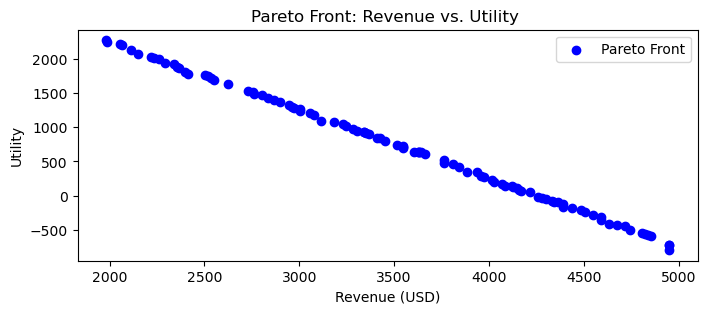

In [13]:
# Plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.scatter(revenue, utility, c='blue', label='Pareto Front')
ax.set_xlabel('Revenue (USD)')
ax.set_ylabel('Utility')
ax.set_title('Pareto Front: Revenue vs. Utility ')
plt.legend()
plt.savefig('pso_n_5.jpg')
plt.show()

In [14]:
Y = []
for i in range(N):
    Y.append([])
    
for i in range(10):
    for j in range(N):
        Y[j].append(pareto_positions[i][j])


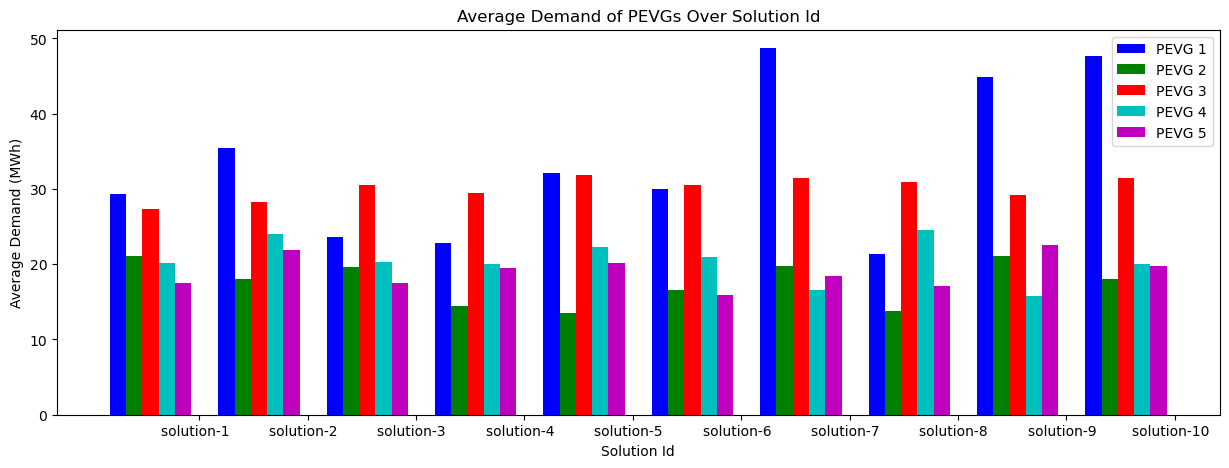

In [15]:
# Colors for different PEVGs
colors = ['b', 'g', 'r', 'c', 'm']
total = 10
x = np.arange(total)
bar_width = 0.15

# Plot bars for each PEVG
plt.figure(figsize=(15, 5))
for i in range(N):
    plt.bar( x + i * bar_width, Y[i], width=bar_width, color=colors[i], label=f'PEVG {i+1}')


# Labels and Title
plt.xlabel('Solution Id')
plt.ylabel('Average Demand (MWh)')
plt.title('Average Demand of PEVGs Over Solution Id')
plt.xticks(x + bar_width * (N ), [f'solution-{i+1}  ' for i in range(total)])  # Adjust X-ticks
plt.legend()
plt.savefig('pso_top_10.jpg')
plt.show()